In [1]:
import os
import numpy as np
from PIL import Image
import astra
import json
import matplotlib.pyplot as plt
from PythonTools.raw2py import raw2py
from PythonTools.py2rek import py2rek
# Define the path to the folder containing the TIFF and jsons files
folder_path = r"/home/abtin/CT+Ultrasound/Reconstruction/Steel_aRTist_Data/Steel_aRTist_Data"

# Function to load TIFF and json files
def load_tiff_images(folder_path):
    # List all files in the folder and sort them to ensure the correct order
    tiff_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.tiff') or f.endswith('.tif')])

    #This is a list for all of the json files data
    all_data = []

    
    # Initialize an empty list to store the images
    images = np.zeros((2200, 200, 700))
    I0 = 46427
    i = 0
    # Loop through each TIFF file and load it as a NumPy array
    for tiff_file in tiff_files:
        tiff_file_path = os.path.join(folder_path, tiff_file)
        image = Image.open(tiff_file_path)
        image_array = np.array(image)
        image_array = np.log(I0/image_array)
        images[:, i, :] = image_array
        i = i + 1
        
        json_file_path = tiff_file_path.replace(".tif", ".json")
        with open(json_file_path, 'r') as json_file:
            data = json.load(json_file)
            #Extract the infomration that we want
            focal_spot_position_mm = np.array(data.get("focal_spot_position_mm"))
            detector_center_position_mm = np.array(data.get("detector_center_position_mm"))
            detector_center_orientation_matrix = np.array(data.get("detector_center_orientation_matrix"))
            pixel_pitch_mm = np.array(data.get("pixel_pitch_mm"))

             # Convert units from mm to µm where applicable
            focal_spot_position_um = focal_spot_position_mm * 1000
            detector_center_position_um = detector_center_position_mm * 1000
            pixel_pitch_um = pixel_pitch_mm * 1000
            #print(pixel_pitch_um)
            Detector_row_direction = detector_center_orientation_matrix[:,0]
            #print( Detector_row_direction)
            Detector_column_direction = detector_center_orientation_matrix[:,1]
            #print(Detector_column_direction)
            Detector_row_direction_with_pitch = Detector_row_direction *  pixel_pitch_um[0]
            Detector_column_direction_with_pitch = Detector_column_direction *  pixel_pitch_um[1]

            # Construct a vector with all necessary parameters
            cone_vec=np.array([*focal_spot_position_um, *detector_center_position_um, *Detector_row_direction_with_pitch,*Detector_column_direction_with_pitch ])

             # Append the vector to the list of all data
            all_data.append(cone_vec)


    # Stack the images to create a 3D array and convert JSON data to a NumPy array
    images_3d = np.stack(images, axis=0)
    all_data=np.array(all_data)
    return images_3d, all_data

# Load the TIFF images

images_3d_array, cone_vecs = load_tiff_images(folder_path)
print(cone_vecs[0])


# Display the shape of the 3D array to confirm loading
print("Loaded 3D image array shape:", images_3d_array.shape)


[0.00000000e+00 0.00000000e+00 6.00000000e+05 0.00000000e+00
 0.00000000e+00 3.05175781e-02 1.38999999e+02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.38999999e+02 0.00000000e+00]
Loaded 3D image array shape: (2200, 200, 700)


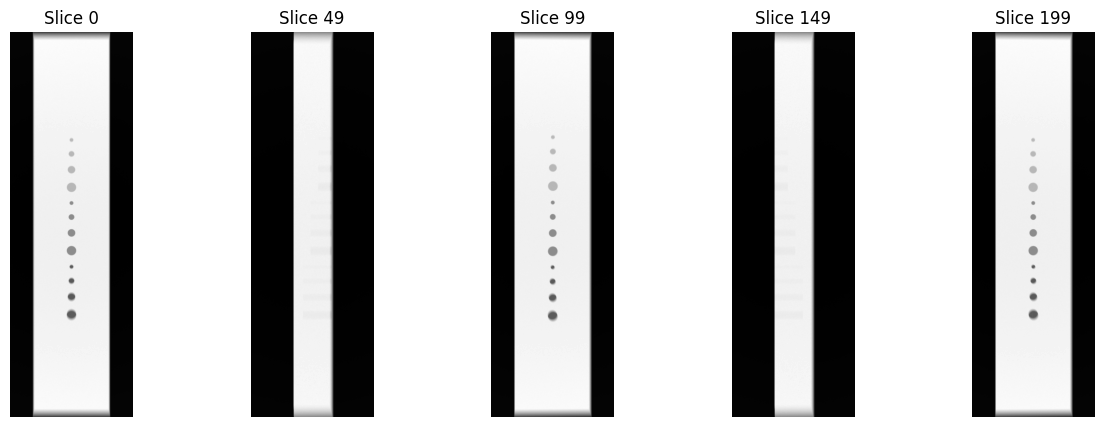

In [2]:
def visualize_projections(volume, axis=0, num_slices=5):
    # Determine the number of slices along the specified axis
    total_slices = volume.shape[axis]
    
    # Select slices to display evenly spaced across the volume
    slice_indices = np.linspace(0, total_slices - 1, num_slices, dtype=int)
    
    # Plot the selected slices
    fig, axes = plt.subplots(1, num_slices, figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        if axis == 0:
            slice_image = volume[idx, :, :]
        elif axis == 1:
            slice_image = volume[:, idx, :]
        else:
            slice_image = volume[:, :, idx]
        
        axes[i].imshow(slice_image, cmap='gray')
        axes[i].set_title(f'Slice {idx}')
        axes[i].axis('off')
    
    plt.show()
# Visualize slices from the reconstructed volume along the first axis
visualize_projections(images_3d_array, axis=1, num_slices=5)


In [ ]:
num_projections = images_3d_array.shape[1]  # Number of projections
detector_pixel_x = images_3d_array.shape[2]  # Width of each projection
detector_pixel_y = images_3d_array.shape[0]  # Height of each projection
focal_object_Dis = 400
object_Detector_Dis = 200
distance_source_detector = 600  # Distance from source to detector 
distance_source_origin = 400    # Distance from source to object 
# Create a volume geometry
n_rows = 384
n_cols = 1024
n_slices = 384
volume_center_position_um = [0,0,200000]
volume_voxel_size_um = 139 * 2

min_x = volume_center_position_um[0] - n_rows/2 * volume_voxel_size_um
max_x = volume_center_position_um[0] + n_rows/2 * volume_voxel_size_um

min_y = volume_center_position_um[1] - n_cols/2 * volume_voxel_size_um
max_y = volume_center_position_um[1] + n_cols/2 * volume_voxel_size_um

min_z = volume_center_position_um[2] - n_slices/2 * volume_voxel_size_um
max_z = volume_center_position_um[2] + n_slices/2 * volume_voxel_size_um

vol_geom = astra.create_vol_geom(n_cols, n_rows, n_slices, min_x, max_x, min_y, max_y, min_z, max_z)

# Create a 3D projection geometry (parallel beam)
#angles = np.linspace(0, 2 * np.pi, num_projections, endpoint=False)
proj_geom = astra.create_proj_geom('cone_vec', detector_pixel_y, detector_pixel_x, cone_vecs)

#print(angles)


In [4]:
# Create a 3D projection data object
#proj_id, proj_data = astra.create_sino3d_gpu(images_3d_array, proj_geom, vol_geom)
proj_id = astra.data3d.create('-sino',proj_geom, images_3d_array)



In [5]:
# Set up and run the SIRT3D-CUDA reconstruction algorithm
reconstruction_id = astra.data3d.create('-vol', vol_geom)
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ProjectionDataId'] = proj_id
cfg['ReconstructionDataId'] = reconstruction_id
#cfg['option'] = {'MinConstraint': 0}  # Ensure non-negative values in the reconstruction

# Create and run the reconstruction algorithm
algo_id = astra.algorithm.create(cfg)
astra.algorithm.run(algo_id, 100)  # Run for 100 iterations (you can adjust this number)

# Get the reconstructed volume
reconstructed_volume = astra.data3d.get(reconstruction_id)

# Clean up memory
astra.algorithm.delete(algo_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(proj_id)

# Save or further process the reconstructed volume
print("Reconstruction complete. Volume shape:", reconstructed_volume.shape)

Reconstruction complete. Volume shape: (384, 1024, 384)


In [6]:

Reconstruction_path = r'/home/abtin/CT+Ultrasound/Reconstruction/Reconstruction_path/Reconstruction_Steel2.rek'
py2rek(reconstructed_volume, Reconstruction_path)